In [1]:
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter

In [11]:
train_transform = transforms.Compose([ 
    transforms.Resize((224,224)),
#     transforms.RandomResizedCrop(size=(256,256)),
    transforms.RandomRotation(7.5),
    transforms.RandomHorizontalFlip(),
#     transforms.CenterCrop(size = 224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
       
])

test_transform = transforms.Compose([
        transforms.Resize((224,224)),
#         transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

# test_transform = transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(size=224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406],
#                              [0.229, 0.224, 0.225])
#     ])

In [4]:
#Data Loading
train_dir = 'train/'
test_dir = 'test/'

bs = 16

num_classes = 2

train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

print(len(train_data),len(test_data))


train_data_loader = DataLoader(train_data,batch_size=bs,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=bs, shuffle=False)

2891 459


In [19]:
test_data

Dataset ImageFolder
    Number of datapoints: 459
    Root location: test/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [20]:
train_data_loader.dataset.classes

['ID', 'NON_ID']

In [21]:
resnet50 = models.resnet50(pretrained=True)

In [34]:
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
for param in resnet50.parameters():
    param.require_grad = True

In [23]:
from torch import nn, optim

In [24]:
resnet50.fc = nn.Sequential(
    nn.Linear(2048,256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2),
    nn.LogSoftmax(dim=1)    

)

In [25]:
device = 'cuda'
model = resnet50

In [26]:
model = model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [75]:
# writer = SummaryWriter() 

In [27]:
epochs = 18
training_loss = []
testing_loss = []
accuracy_list = []
for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch+1,epochs))
    model.train()
    
    train_loss = 0.0
    test_loss = 0.0
    test_acc = 0.0
    

    
    for i , (inputs,labels) in enumerate(train_data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        output = model(inputs)
        loss = loss_func(output,labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*inputs.size(0)
#         writer.add_scalar('loss', loss, epoch)
        print("Batch number: {:03d}, Training_Loss: {:.4f},".format(i, loss.item()))


    with torch.no_grad():
        model.eval()
        num_correct = 0
        num_examples = 0
        

        for j , (inputs, target) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            target = target.to(device)

            output = model(inputs)
            loss = loss_func(output, target)
            correct = torch.eq(torch.max(torch.functional.F.softmax(output), dim=1)[1], target).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
            test_loss += loss.item()*inputs.size(0)
            print("Test Batch number: {:03d}, Test_Loss: {:.4f}, Accuracy:{:.2f}".format(j, loss.item(),num_correct/num_examples))
#             writer.add_scalar('accuracy', num_correct / num_examples, epoch)
#             writer.add_scalar('Test_loss', loss, epoch)
#             test_acc += num_correct

        
        
        
        
    avg_train_loss = train_loss/len(train_data)
    avg_test_loss = test_loss/len(test_data)
    avg_acc = num_correct/len(test_data)
    training_loss.append(avg_train_loss)
    testing_loss.append(avg_test_loss)
    accuracy_list.append(avg_acc)
    
#     if avg_test_loss == avg_train_loss:
#         break
        
        

Epoch: 1/18
Batch number: 000, Training_Loss: 0.6738,
Batch number: 001, Training_Loss: 0.8060,
Batch number: 002, Training_Loss: 0.9535,
Batch number: 003, Training_Loss: 0.3581,
Batch number: 004, Training_Loss: 0.5232,
Batch number: 005, Training_Loss: 0.4232,
Batch number: 006, Training_Loss: 0.4387,
Batch number: 007, Training_Loss: 0.5545,
Batch number: 008, Training_Loss: 0.2853,
Batch number: 009, Training_Loss: 0.2616,
Batch number: 010, Training_Loss: 0.2485,
Batch number: 011, Training_Loss: 0.4640,
Batch number: 012, Training_Loss: 0.4272,
Batch number: 013, Training_Loss: 0.2858,
Batch number: 014, Training_Loss: 0.4032,
Batch number: 015, Training_Loss: 0.6747,
Batch number: 016, Training_Loss: 0.7606,
Batch number: 017, Training_Loss: 0.3444,
Batch number: 018, Training_Loss: 0.3235,
Batch number: 019, Training_Loss: 0.4766,
Batch number: 020, Training_Loss: 0.8495,
Batch number: 021, Training_Loss: 1.0114,
Batch number: 022, Training_Loss: 1.4871,
Batch number: 023, Tra

C:\Users\Akansh Maurya\anaconda3\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test Batch number: 000, Test_Loss: 0.3358, Accuracy:0.75
Test Batch number: 001, Test_Loss: 0.3854, Accuracy:0.75
Test Batch number: 002, Test_Loss: 0.3062, Accuracy:0.75
Test Batch number: 003, Test_Loss: 0.3608, Accuracy:0.77
Test Batch number: 004, Test_Loss: 0.3535, Accuracy:0.75
Test Batch number: 005, Test_Loss: 0.2828, Accuracy:0.77
Test Batch number: 006, Test_Loss: 0.3528, Accuracy:0.77
Test Batch number: 007, Test_Loss: 0.4130, Accuracy:0.77
Test Batch number: 008, Test_Loss: 0.6557, Accuracy:0.75
Test Batch number: 009, Test_Loss: 0.3357, Accuracy:0.76
Test Batch number: 010, Test_Loss: 0.1085, Accuracy:0.78
Test Batch number: 011, Test_Loss: 0.2009, Accuracy:0.79
Test Batch number: 012, Test_Loss: 0.6259, Accuracy:0.78
Test Batch number: 013, Test_Loss: 0.4699, Accuracy:0.78
Test Batch number: 014, Test_Loss: 0.3201, Accuracy:0.78
Test Batch number: 015, Test_Loss: 0.3460, Accuracy:0.79
Test Batch number: 016, Test_Loss: 0.3656, Accuracy:0.79
Test Batch number: 017, Test_Lo

Batch number: 156, Training_Loss: 0.3118,
Batch number: 157, Training_Loss: 0.0620,
Batch number: 158, Training_Loss: 0.0769,
Batch number: 159, Training_Loss: 0.4869,
Batch number: 160, Training_Loss: 0.1283,
Batch number: 161, Training_Loss: 0.2158,
Batch number: 162, Training_Loss: 0.6967,
Batch number: 163, Training_Loss: 0.6273,
Batch number: 164, Training_Loss: 0.1091,
Batch number: 165, Training_Loss: 0.3981,
Batch number: 166, Training_Loss: 0.0937,
Batch number: 167, Training_Loss: 0.3492,
Batch number: 168, Training_Loss: 0.1463,
Batch number: 169, Training_Loss: 0.2846,
Batch number: 170, Training_Loss: 0.4344,
Batch number: 171, Training_Loss: 0.1788,
Batch number: 172, Training_Loss: 0.7843,
Batch number: 173, Training_Loss: 0.2076,
Batch number: 174, Training_Loss: 0.1021,
Batch number: 175, Training_Loss: 0.2125,
Batch number: 176, Training_Loss: 0.2118,
Batch number: 177, Training_Loss: 0.4601,
Batch number: 178, Training_Loss: 0.2090,
Batch number: 179, Training_Loss: 

Batch number: 131, Training_Loss: 0.1824,
Batch number: 132, Training_Loss: 0.0242,
Batch number: 133, Training_Loss: 0.0315,
Batch number: 134, Training_Loss: 0.3846,
Batch number: 135, Training_Loss: 0.8605,
Batch number: 136, Training_Loss: 0.4845,
Batch number: 137, Training_Loss: 0.5027,
Batch number: 138, Training_Loss: 0.2962,
Batch number: 139, Training_Loss: 0.3640,
Batch number: 140, Training_Loss: 0.1816,
Batch number: 141, Training_Loss: 0.1037,
Batch number: 142, Training_Loss: 0.5147,
Batch number: 143, Training_Loss: 0.1248,
Batch number: 144, Training_Loss: 0.1172,
Batch number: 145, Training_Loss: 0.1988,
Batch number: 146, Training_Loss: 0.4821,
Batch number: 147, Training_Loss: 0.1216,
Batch number: 148, Training_Loss: 0.2939,
Batch number: 149, Training_Loss: 0.2301,
Batch number: 150, Training_Loss: 0.4175,
Batch number: 151, Training_Loss: 0.8579,
Batch number: 152, Training_Loss: 0.7522,
Batch number: 153, Training_Loss: 0.2544,
Batch number: 154, Training_Loss: 

Batch number: 106, Training_Loss: 0.2261,
Batch number: 107, Training_Loss: 0.0826,
Batch number: 108, Training_Loss: 0.2321,
Batch number: 109, Training_Loss: 0.2731,
Batch number: 110, Training_Loss: 0.0865,
Batch number: 111, Training_Loss: 0.1141,
Batch number: 112, Training_Loss: 0.0777,
Batch number: 113, Training_Loss: 0.5348,
Batch number: 114, Training_Loss: 0.1820,
Batch number: 115, Training_Loss: 0.2810,
Batch number: 116, Training_Loss: 0.0487,
Batch number: 117, Training_Loss: 0.1996,
Batch number: 118, Training_Loss: 0.2450,
Batch number: 119, Training_Loss: 0.1127,
Batch number: 120, Training_Loss: 0.4392,
Batch number: 121, Training_Loss: 0.1506,
Batch number: 122, Training_Loss: 0.9182,
Batch number: 123, Training_Loss: 0.1925,
Batch number: 124, Training_Loss: 0.1826,
Batch number: 125, Training_Loss: 0.4614,
Batch number: 126, Training_Loss: 0.0762,
Batch number: 127, Training_Loss: 0.1942,
Batch number: 128, Training_Loss: 0.4339,
Batch number: 129, Training_Loss: 

Batch number: 081, Training_Loss: 0.1223,
Batch number: 082, Training_Loss: 0.0539,
Batch number: 083, Training_Loss: 0.1796,
Batch number: 084, Training_Loss: 0.1996,
Batch number: 085, Training_Loss: 0.1905,
Batch number: 086, Training_Loss: 0.0672,
Batch number: 087, Training_Loss: 0.3410,
Batch number: 088, Training_Loss: 0.4494,
Batch number: 089, Training_Loss: 0.0938,
Batch number: 090, Training_Loss: 0.2018,
Batch number: 091, Training_Loss: 0.0437,
Batch number: 092, Training_Loss: 0.0663,
Batch number: 093, Training_Loss: 0.0737,
Batch number: 094, Training_Loss: 0.0185,
Batch number: 095, Training_Loss: 0.4558,
Batch number: 096, Training_Loss: 0.0972,
Batch number: 097, Training_Loss: 0.4554,
Batch number: 098, Training_Loss: 0.1433,
Batch number: 099, Training_Loss: 0.1643,
Batch number: 100, Training_Loss: 0.4710,
Batch number: 101, Training_Loss: 0.2715,
Batch number: 102, Training_Loss: 0.3219,
Batch number: 103, Training_Loss: 0.0611,
Batch number: 104, Training_Loss: 

Batch number: 056, Training_Loss: 0.2106,
Batch number: 057, Training_Loss: 0.0513,
Batch number: 058, Training_Loss: 0.1078,
Batch number: 059, Training_Loss: 0.1214,
Batch number: 060, Training_Loss: 0.2129,
Batch number: 061, Training_Loss: 0.1022,
Batch number: 062, Training_Loss: 0.1023,
Batch number: 063, Training_Loss: 0.1542,
Batch number: 064, Training_Loss: 0.1390,
Batch number: 065, Training_Loss: 0.1430,
Batch number: 066, Training_Loss: 0.4759,
Batch number: 067, Training_Loss: 0.0794,
Batch number: 068, Training_Loss: 0.1079,
Batch number: 069, Training_Loss: 0.2331,
Batch number: 070, Training_Loss: 0.1798,
Batch number: 071, Training_Loss: 0.0918,
Batch number: 072, Training_Loss: 0.0755,
Batch number: 073, Training_Loss: 0.0468,
Batch number: 074, Training_Loss: 0.1404,
Batch number: 075, Training_Loss: 0.0868,
Batch number: 076, Training_Loss: 0.4071,
Batch number: 077, Training_Loss: 0.0166,
Batch number: 078, Training_Loss: 0.0420,
Batch number: 079, Training_Loss: 

Batch number: 031, Training_Loss: 0.0756,
Batch number: 032, Training_Loss: 0.0603,
Batch number: 033, Training_Loss: 0.1109,
Batch number: 034, Training_Loss: 0.1306,
Batch number: 035, Training_Loss: 0.1794,
Batch number: 036, Training_Loss: 0.3058,
Batch number: 037, Training_Loss: 0.0164,
Batch number: 038, Training_Loss: 0.2420,
Batch number: 039, Training_Loss: 0.3614,
Batch number: 040, Training_Loss: 0.1243,
Batch number: 041, Training_Loss: 0.2606,
Batch number: 042, Training_Loss: 0.0901,
Batch number: 043, Training_Loss: 0.1654,
Batch number: 044, Training_Loss: 0.2335,
Batch number: 045, Training_Loss: 0.0691,
Batch number: 046, Training_Loss: 0.1312,
Batch number: 047, Training_Loss: 0.0846,
Batch number: 048, Training_Loss: 0.6067,
Batch number: 049, Training_Loss: 0.1044,
Batch number: 050, Training_Loss: 0.1929,
Batch number: 051, Training_Loss: 0.1878,
Batch number: 052, Training_Loss: 0.0820,
Batch number: 053, Training_Loss: 0.2435,
Batch number: 054, Training_Loss: 

Batch number: 006, Training_Loss: 0.0554,
Batch number: 007, Training_Loss: 0.2410,
Batch number: 008, Training_Loss: 0.1191,
Batch number: 009, Training_Loss: 0.0571,
Batch number: 010, Training_Loss: 0.3415,
Batch number: 011, Training_Loss: 0.0408,
Batch number: 012, Training_Loss: 0.1242,
Batch number: 013, Training_Loss: 0.0738,
Batch number: 014, Training_Loss: 0.0598,
Batch number: 015, Training_Loss: 0.1142,
Batch number: 016, Training_Loss: 0.0469,
Batch number: 017, Training_Loss: 0.3595,
Batch number: 018, Training_Loss: 0.1509,
Batch number: 019, Training_Loss: 0.1558,
Batch number: 020, Training_Loss: 0.1227,
Batch number: 021, Training_Loss: 0.0709,
Batch number: 022, Training_Loss: 0.0297,
Batch number: 023, Training_Loss: 0.1307,
Batch number: 024, Training_Loss: 0.1251,
Batch number: 025, Training_Loss: 0.1104,
Batch number: 026, Training_Loss: 0.0561,
Batch number: 027, Training_Loss: 0.2215,
Batch number: 028, Training_Loss: 0.0613,
Batch number: 029, Training_Loss: 

Test Batch number: 015, Test_Loss: 0.1111, Accuracy:0.96
Test Batch number: 016, Test_Loss: 0.0384, Accuracy:0.97
Test Batch number: 017, Test_Loss: 0.0492, Accuracy:0.97
Test Batch number: 018, Test_Loss: 0.2254, Accuracy:0.96
Test Batch number: 019, Test_Loss: 0.0888, Accuracy:0.96
Test Batch number: 020, Test_Loss: 0.0754, Accuracy:0.96
Test Batch number: 021, Test_Loss: 0.1178, Accuracy:0.96
Test Batch number: 022, Test_Loss: 0.1184, Accuracy:0.96
Test Batch number: 023, Test_Loss: 0.1019, Accuracy:0.96
Test Batch number: 024, Test_Loss: 0.0747, Accuracy:0.96
Test Batch number: 025, Test_Loss: 0.0762, Accuracy:0.96
Test Batch number: 026, Test_Loss: 1.2475, Accuracy:0.95
Test Batch number: 027, Test_Loss: 0.0275, Accuracy:0.95
Test Batch number: 028, Test_Loss: 0.7381, Accuracy:0.95
Epoch: 9/18
Batch number: 000, Training_Loss: 0.1760,
Batch number: 001, Training_Loss: 0.3269,
Batch number: 002, Training_Loss: 0.0675,
Batch number: 003, Training_Loss: 0.2706,
Batch number: 004, Tra

Batch number: 176, Training_Loss: 0.0644,
Batch number: 177, Training_Loss: 0.1720,
Batch number: 178, Training_Loss: 0.1791,
Batch number: 179, Training_Loss: 0.1957,
Batch number: 180, Training_Loss: 0.0761,
Test Batch number: 000, Test_Loss: 0.1151, Accuracy:0.94
Test Batch number: 001, Test_Loss: 0.0778, Accuracy:0.97
Test Batch number: 002, Test_Loss: 0.0407, Accuracy:0.98
Test Batch number: 003, Test_Loss: 0.1612, Accuracy:0.97
Test Batch number: 004, Test_Loss: 0.2696, Accuracy:0.95
Test Batch number: 005, Test_Loss: 0.1019, Accuracy:0.95
Test Batch number: 006, Test_Loss: 0.1440, Accuracy:0.95
Test Batch number: 007, Test_Loss: 0.1183, Accuracy:0.95
Test Batch number: 008, Test_Loss: 0.1381, Accuracy:0.94
Test Batch number: 009, Test_Loss: 0.2059, Accuracy:0.94
Test Batch number: 010, Test_Loss: 0.0402, Accuracy:0.94
Test Batch number: 011, Test_Loss: 0.0172, Accuracy:0.95
Test Batch number: 012, Test_Loss: 0.1484, Accuracy:0.95
Test Batch number: 013, Test_Loss: 0.0624, Accura

Batch number: 151, Training_Loss: 0.1111,
Batch number: 152, Training_Loss: 0.2015,
Batch number: 153, Training_Loss: 0.0902,
Batch number: 154, Training_Loss: 0.0731,
Batch number: 155, Training_Loss: 0.3143,
Batch number: 156, Training_Loss: 0.1411,
Batch number: 157, Training_Loss: 0.2198,
Batch number: 158, Training_Loss: 0.0725,
Batch number: 159, Training_Loss: 0.0714,
Batch number: 160, Training_Loss: 0.2539,
Batch number: 161, Training_Loss: 0.0926,
Batch number: 162, Training_Loss: 0.2416,
Batch number: 163, Training_Loss: 0.4644,
Batch number: 164, Training_Loss: 0.0993,
Batch number: 165, Training_Loss: 0.1728,
Batch number: 166, Training_Loss: 0.0667,
Batch number: 167, Training_Loss: 0.0858,
Batch number: 168, Training_Loss: 0.0426,
Batch number: 169, Training_Loss: 0.0361,
Batch number: 170, Training_Loss: 0.3590,
Batch number: 171, Training_Loss: 0.1399,
Batch number: 172, Training_Loss: 0.1988,
Batch number: 173, Training_Loss: 0.2321,
Batch number: 174, Training_Loss: 

Batch number: 126, Training_Loss: 0.9813,
Batch number: 127, Training_Loss: 0.0188,
Batch number: 128, Training_Loss: 0.0229,
Batch number: 129, Training_Loss: 0.0638,
Batch number: 130, Training_Loss: 0.2083,
Batch number: 131, Training_Loss: 0.3384,
Batch number: 132, Training_Loss: 0.0923,
Batch number: 133, Training_Loss: 0.0175,
Batch number: 134, Training_Loss: 0.4237,
Batch number: 135, Training_Loss: 0.1950,
Batch number: 136, Training_Loss: 0.0370,
Batch number: 137, Training_Loss: 0.0130,
Batch number: 138, Training_Loss: 0.1044,
Batch number: 139, Training_Loss: 0.6351,
Batch number: 140, Training_Loss: 0.1631,
Batch number: 141, Training_Loss: 0.2066,
Batch number: 142, Training_Loss: 0.2072,
Batch number: 143, Training_Loss: 0.0973,
Batch number: 144, Training_Loss: 0.0244,
Batch number: 145, Training_Loss: 0.2752,
Batch number: 146, Training_Loss: 0.0580,
Batch number: 147, Training_Loss: 0.1591,
Batch number: 148, Training_Loss: 0.2933,
Batch number: 149, Training_Loss: 

Batch number: 101, Training_Loss: 0.3391,
Batch number: 102, Training_Loss: 0.2373,
Batch number: 103, Training_Loss: 0.0703,
Batch number: 104, Training_Loss: 0.0784,
Batch number: 105, Training_Loss: 0.1449,
Batch number: 106, Training_Loss: 0.1590,
Batch number: 107, Training_Loss: 0.0273,
Batch number: 108, Training_Loss: 0.0677,
Batch number: 109, Training_Loss: 0.0309,
Batch number: 110, Training_Loss: 0.1530,
Batch number: 111, Training_Loss: 0.2089,
Batch number: 112, Training_Loss: 0.0330,
Batch number: 113, Training_Loss: 0.0684,
Batch number: 114, Training_Loss: 0.1045,
Batch number: 115, Training_Loss: 0.3293,
Batch number: 116, Training_Loss: 0.0379,
Batch number: 117, Training_Loss: 0.0775,
Batch number: 118, Training_Loss: 0.2521,
Batch number: 119, Training_Loss: 0.0574,
Batch number: 120, Training_Loss: 0.3624,
Batch number: 121, Training_Loss: 0.7511,
Batch number: 122, Training_Loss: 0.1912,
Batch number: 123, Training_Loss: 0.2016,
Batch number: 124, Training_Loss: 

Batch number: 076, Training_Loss: 0.1067,
Batch number: 077, Training_Loss: 0.2181,
Batch number: 078, Training_Loss: 0.0272,
Batch number: 079, Training_Loss: 0.1031,
Batch number: 080, Training_Loss: 0.2101,
Batch number: 081, Training_Loss: 0.0549,
Batch number: 082, Training_Loss: 0.1392,
Batch number: 083, Training_Loss: 0.0447,
Batch number: 084, Training_Loss: 0.0275,
Batch number: 085, Training_Loss: 0.2137,
Batch number: 086, Training_Loss: 0.0893,
Batch number: 087, Training_Loss: 0.0560,
Batch number: 088, Training_Loss: 0.0659,
Batch number: 089, Training_Loss: 0.0269,
Batch number: 090, Training_Loss: 0.0572,
Batch number: 091, Training_Loss: 0.0661,
Batch number: 092, Training_Loss: 0.2437,
Batch number: 093, Training_Loss: 0.4129,
Batch number: 094, Training_Loss: 0.0296,
Batch number: 095, Training_Loss: 0.0463,
Batch number: 096, Training_Loss: 0.1943,
Batch number: 097, Training_Loss: 0.0962,
Batch number: 098, Training_Loss: 0.4377,
Batch number: 099, Training_Loss: 

Batch number: 051, Training_Loss: 0.0210,
Batch number: 052, Training_Loss: 0.0428,
Batch number: 053, Training_Loss: 0.0691,
Batch number: 054, Training_Loss: 0.0599,
Batch number: 055, Training_Loss: 0.0595,
Batch number: 056, Training_Loss: 0.0391,
Batch number: 057, Training_Loss: 0.2180,
Batch number: 058, Training_Loss: 0.0369,
Batch number: 059, Training_Loss: 0.0593,
Batch number: 060, Training_Loss: 0.0769,
Batch number: 061, Training_Loss: 0.2266,
Batch number: 062, Training_Loss: 0.2763,
Batch number: 063, Training_Loss: 0.2790,
Batch number: 064, Training_Loss: 0.1889,
Batch number: 065, Training_Loss: 0.1509,
Batch number: 066, Training_Loss: 0.1881,
Batch number: 067, Training_Loss: 0.1000,
Batch number: 068, Training_Loss: 0.0676,
Batch number: 069, Training_Loss: 0.0245,
Batch number: 070, Training_Loss: 0.0198,
Batch number: 071, Training_Loss: 0.1615,
Batch number: 072, Training_Loss: 0.3450,
Batch number: 073, Training_Loss: 0.1206,
Batch number: 074, Training_Loss: 

Batch number: 026, Training_Loss: 0.0207,
Batch number: 027, Training_Loss: 0.0517,
Batch number: 028, Training_Loss: 0.1266,
Batch number: 029, Training_Loss: 0.0241,
Batch number: 030, Training_Loss: 0.0500,
Batch number: 031, Training_Loss: 0.0645,
Batch number: 032, Training_Loss: 0.0387,
Batch number: 033, Training_Loss: 0.1463,
Batch number: 034, Training_Loss: 0.1440,
Batch number: 035, Training_Loss: 0.1465,
Batch number: 036, Training_Loss: 0.0156,
Batch number: 037, Training_Loss: 0.0856,
Batch number: 038, Training_Loss: 0.0431,
Batch number: 039, Training_Loss: 0.2810,
Batch number: 040, Training_Loss: 0.0185,
Batch number: 041, Training_Loss: 0.0126,
Batch number: 042, Training_Loss: 0.0527,
Batch number: 043, Training_Loss: 0.0093,
Batch number: 044, Training_Loss: 0.4181,
Batch number: 045, Training_Loss: 0.1957,
Batch number: 046, Training_Loss: 0.0734,
Batch number: 047, Training_Loss: 0.0403,
Batch number: 048, Training_Loss: 0.0071,
Batch number: 049, Training_Loss: 

Batch number: 001, Training_Loss: 0.1448,
Batch number: 002, Training_Loss: 0.2752,
Batch number: 003, Training_Loss: 0.0862,
Batch number: 004, Training_Loss: 0.0173,
Batch number: 005, Training_Loss: 0.0223,
Batch number: 006, Training_Loss: 0.0262,
Batch number: 007, Training_Loss: 0.0367,
Batch number: 008, Training_Loss: 0.0670,
Batch number: 009, Training_Loss: 0.0442,
Batch number: 010, Training_Loss: 0.5412,
Batch number: 011, Training_Loss: 0.2123,
Batch number: 012, Training_Loss: 0.0820,
Batch number: 013, Training_Loss: 0.0984,
Batch number: 014, Training_Loss: 0.0037,
Batch number: 015, Training_Loss: 0.1809,
Batch number: 016, Training_Loss: 0.0532,
Batch number: 017, Training_Loss: 0.0303,
Batch number: 018, Training_Loss: 0.0646,
Batch number: 019, Training_Loss: 0.0653,
Batch number: 020, Training_Loss: 0.0402,
Batch number: 021, Training_Loss: 0.0659,
Batch number: 022, Training_Loss: 0.0808,
Batch number: 023, Training_Loss: 0.0253,
Batch number: 024, Training_Loss: 

Test Batch number: 012, Test_Loss: 0.0328, Accuracy:0.99
Test Batch number: 013, Test_Loss: 0.0076, Accuracy:0.99
Test Batch number: 014, Test_Loss: 0.0220, Accuracy:0.99
Test Batch number: 015, Test_Loss: 0.0261, Accuracy:0.99
Test Batch number: 016, Test_Loss: 0.0082, Accuracy:0.99
Test Batch number: 017, Test_Loss: 0.0317, Accuracy:0.99
Test Batch number: 018, Test_Loss: 0.0156, Accuracy:0.99
Test Batch number: 019, Test_Loss: 0.0101, Accuracy:0.99
Test Batch number: 020, Test_Loss: 0.0056, Accuracy:0.99
Test Batch number: 021, Test_Loss: 0.3068, Accuracy:0.99
Test Batch number: 022, Test_Loss: 0.1240, Accuracy:0.99
Test Batch number: 023, Test_Loss: 0.0251, Accuracy:0.99
Test Batch number: 024, Test_Loss: 0.1537, Accuracy:0.98
Test Batch number: 025, Test_Loss: 0.0259, Accuracy:0.99
Test Batch number: 026, Test_Loss: 0.6778, Accuracy:0.98
Test Batch number: 027, Test_Loss: 0.0496, Accuracy:0.98
Test Batch number: 028, Test_Loss: 0.5184, Accuracy:0.98
Epoch: 17/18
Batch number: 000,

Batch number: 172, Training_Loss: 0.4795,
Batch number: 173, Training_Loss: 0.2189,
Batch number: 174, Training_Loss: 0.3005,
Batch number: 175, Training_Loss: 0.1167,
Batch number: 176, Training_Loss: 0.1179,
Batch number: 177, Training_Loss: 0.1809,
Batch number: 178, Training_Loss: 0.0793,
Batch number: 179, Training_Loss: 0.0755,
Batch number: 180, Training_Loss: 0.1961,
Test Batch number: 000, Test_Loss: 0.1182, Accuracy:0.94
Test Batch number: 001, Test_Loss: 0.1012, Accuracy:0.97
Test Batch number: 002, Test_Loss: 0.0305, Accuracy:0.98
Test Batch number: 003, Test_Loss: 0.0929, Accuracy:0.98
Test Batch number: 004, Test_Loss: 0.0981, Accuracy:0.99
Test Batch number: 005, Test_Loss: 0.0576, Accuracy:0.99
Test Batch number: 006, Test_Loss: 0.1552, Accuracy:0.98
Test Batch number: 007, Test_Loss: 0.1070, Accuracy:0.98
Test Batch number: 008, Test_Loss: 0.0608, Accuracy:0.99
Test Batch number: 009, Test_Loss: 0.2089, Accuracy:0.97
Test Batch number: 010, Test_Loss: 0.0445, Accuracy:

Batch number: 147, Training_Loss: 0.0101,
Batch number: 148, Training_Loss: 0.0517,
Batch number: 149, Training_Loss: 0.0371,
Batch number: 150, Training_Loss: 0.0275,
Batch number: 151, Training_Loss: 0.0591,
Batch number: 152, Training_Loss: 0.3381,
Batch number: 153, Training_Loss: 0.0682,
Batch number: 154, Training_Loss: 0.2292,
Batch number: 155, Training_Loss: 0.0145,
Batch number: 156, Training_Loss: 0.2092,
Batch number: 157, Training_Loss: 0.1655,
Batch number: 158, Training_Loss: 0.0462,
Batch number: 159, Training_Loss: 0.0888,
Batch number: 160, Training_Loss: 0.0123,
Batch number: 161, Training_Loss: 0.0051,
Batch number: 162, Training_Loss: 0.1041,
Batch number: 163, Training_Loss: 0.1728,
Batch number: 164, Training_Loss: 0.0593,
Batch number: 165, Training_Loss: 0.0661,
Batch number: 166, Training_Loss: 0.0803,
Batch number: 167, Training_Loss: 0.0552,
Batch number: 168, Training_Loss: 0.1084,
Batch number: 169, Training_Loss: 0.0274,
Batch number: 170, Training_Loss: 

In [31]:
min(training_loss)

0.11601852205530742

In [32]:
training_loss.index(min(training_loss))

17

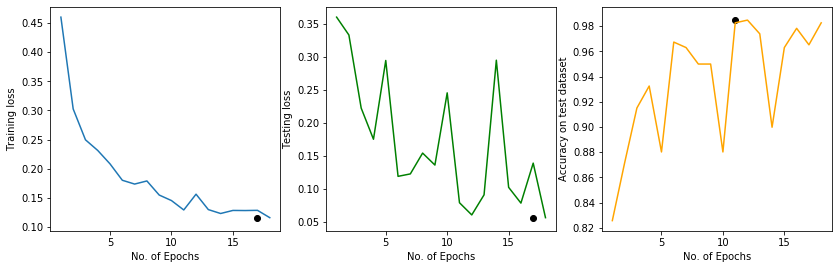

In [33]:
plt.figure(1,figsize=(14,14))
plt.subplot(331)
plt.xlabel('No. of Epochs')
plt.ylabel('Training loss')
plt.plot(list(range(1,19)),training_loss)
plt.scatter(training_loss.index(min(training_loss)),min(training_loss),color = 'black')
plt.subplot(332)
plt.xlabel('No. of Epochs')
plt.ylabel('Testing loss')
plt.plot(list(range(1,19)),testing_loss,color = 'green')
plt.scatter(testing_loss.index(min(testing_loss)),min(testing_loss),color = 'black')
plt.subplot(333)
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy on test dataset')
plt.plot(list(range(1,19)),accuracy_list,color = 'orange')
plt.scatter(accuracy_list.index(max(accuracy_list)),max(accuracy_list),color = 'black')

In [34]:
torch.save(model,'./iter_5.pth')

#### Use Iter_3.pth

In [12]:
model = torch.load('iter_4.pth')

In [13]:
from PIL import Image

In [32]:
classes = ['ID','NON_ID']
def predict(model, test_image_name):
     
    transform = test_transform
 
    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
     
    test_image_tensor = transform(test_image)
#     print(test_image_tensor.size())
 
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
     
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        _ , b = (torch.max(out,1))
#         print(b)
#         print(train_data_loader.dataset.classes[b.item()])
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
#     print(ps)
#     print(topk,topclass)
    return classes[b.item()], topk.cpu().numpy()[0][0]

torch.Size([3, 224, 224])


('NON_ID', 0.75240993)

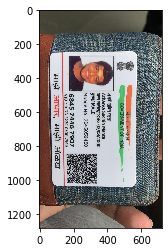

In [15]:
predict(model,'./Atharva_60.jpeg')

In [19]:
classes = ['ID','NON_ID']

In [31]:
predict(model,'./Sivasankar_49.jpg')

('ID', 0.9999995)

('ID', 0.99908394)

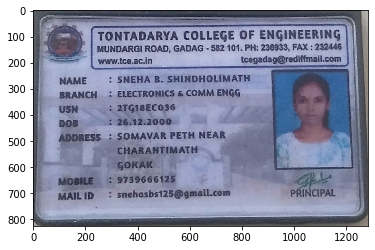

In [40]:
predict(model,'./Test/ID/Sneha_13.jpg')

torch.Size([3, 224, 224])


('NON_ID', 0.92852306)

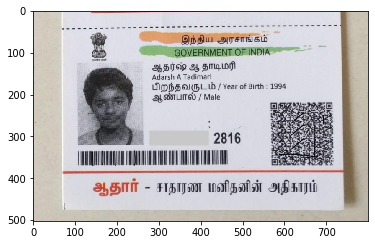

In [16]:
predict(model,'./adhw.png')

('NON_ID', 0.83299786)

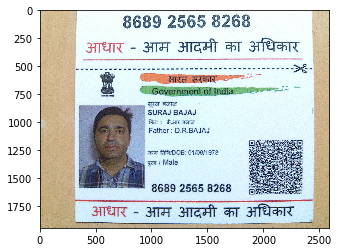

In [38]:
predict(model,'./Suraj_Bajaj_Aadhar_Card.jpg')

('NON_ID', 0.99999905)

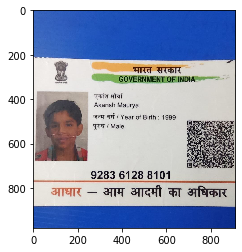

In [23]:
predict(model,'./WhatsApp Image 2020-03-23 at 8.35.57 5g4.jpeg')

('NON_ID', 0.99745166)

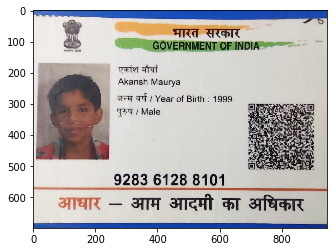

In [29]:
predict(model,'./WhatsApp Image 2020-03-23 at 8.35.57 PM (2).jpeg')

('NON_ID', 0.9181464)

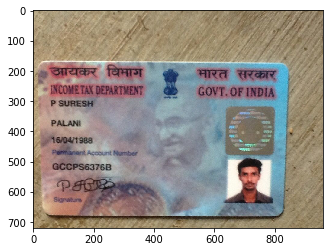

In [31]:
predict(model,'./pan_card_2.jpeg')

('ID', 0.8929448)

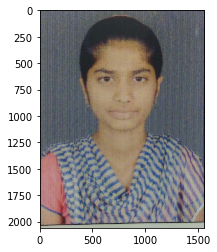

In [18]:
predict(model,'./Priyanka_59.jpg')

('NON_ID', 0.99911296)

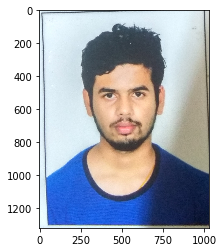

In [19]:
predict(model,'./Prajwal_70.jpg')

('NON_ID', 0.9996992)

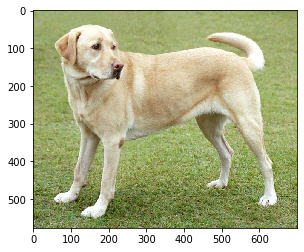

In [20]:
predict(model,'./dog.jpg')

('NON_ID', 0.9851311)

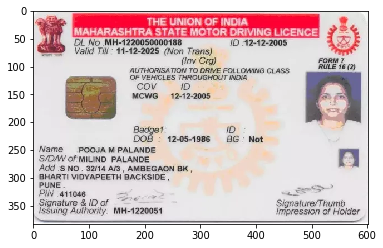

In [21]:
predict(model,'./3f93b4_abce4236883c45d5bea628cbaac00b7b_mv2.png')

('NON_ID', 0.999959)

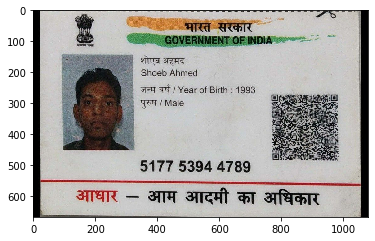

In [22]:
predict(model,'./adhtest.jpg')

### Wrongly classified as ID card

In [59]:
import os

In [60]:
wrong_test_NON_ID = []
for i in os.listdir(test_dir+'NON_ID/'):
    try:
        a = predict(model,test_dir+'NON_ID/'+ i)
        if a[0] != 'NON_ID':
            wrong_test_NON_ID.append(i)
            
    except:
        pass

In [61]:
wrong_test_NON_ID

['2af1b5df0938aa7f.jpg',
 'Govind_8.jpg',
 'images64 (5).jpg',
 'image_0282.jpg',
 'smita_92.jpg']

In [63]:
img0 = Image.open(test_dir+'NON_ID/'+wrong_test_NON_ID[0])
img1 = Image.open(test_dir+'NON_ID/'+wrong_test_NON_ID[1])
img2 = Image.open(test_dir+'NON_ID/'+wrong_test_NON_ID[2])
img3 = Image.open(test_dir+'NON_ID/'+wrong_test_NON_ID[3])
img4 = Image.open(test_dir+'NON_ID/'+wrong_test_NON_ID[4])

### These Images are wrongly classified as ID cards

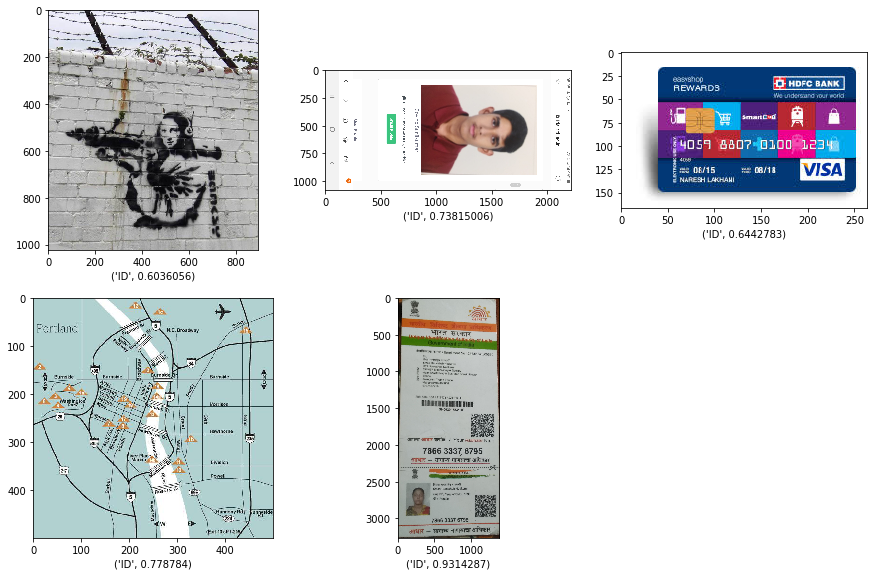

In [64]:
plt.figure(1,figsize=(15,15))
plt.subplot(331)
plt.xlabel(predict(model,test_dir+'NON_ID/'+wrong_test_NON_ID[0]))
plt.imshow(img0)
plt.subplot(332)
plt.xlabel(predict(model,test_dir+'NON_ID/'+wrong_test_NON_ID[1]))
plt.imshow(img1)
plt.subplot(333)
plt.xlabel(predict(model,test_dir+'NON_ID/'+wrong_test_NON_ID[2]))
plt.imshow(img2)
plt.subplot(334)
plt.xlabel(predict(model,test_dir+'NON_ID/'+wrong_test_NON_ID[3]))
plt.imshow(img3)
plt.subplot(335)
plt.xlabel(predict(model,test_dir+'NON_ID/'+wrong_test_NON_ID[4]))
plt.imshow(img4)

plt.show()


In [65]:
wrong_test_ID = []
for i in os.listdir(test_dir+'ID/'):
    try:
        a = predict(model,test_dir+'ID/'+ i)
        if a[0] != 'ID':
            wrong_test_ID.append(i)
            
    except:
        pass

In [66]:
wrong_test_ID 

['Sujith_49.jpg']

('ID', 0.71009684)

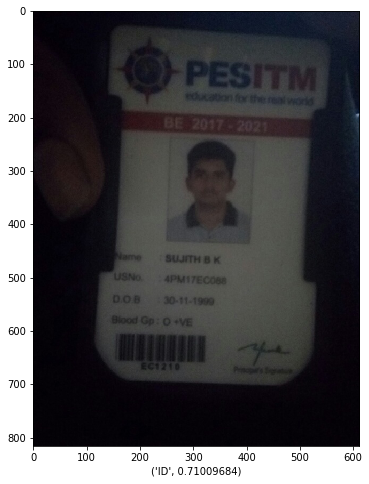

In [29]:
plt.figure(1,(8,8))
plt.xlabel(predict(model,'Test/ID/Sujith_49.jpg'))
plt.imshow(Image.open('Test/ID/Sujith_49.jpg'))
predict(model,'./Test/ID/Sujith_49.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'Test/ID/Dasharatham_78.png'

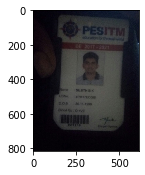

In [71]:
img = {}
for i,j in enumerate(wrong_test_ID):
    img[str(i)] = Image.open('Test/ID/'+str(j))
    if i >= 9:
        plt.figure(2,figsize=(15,15))
        plt.subplot(541+i+1)
        plt.imshow(img[str(i)])
    else:
        plt.figure(3,figsize=(15,15))
        plt.subplot(541+i)
        plt.imshow(img[str(i)])
    
    

In [67]:
wrong_train_NON_ID = []
for i in os.listdir(train_dir+'NON_ID/'):
    try:
        a = predict(model,train_dir+'NON_ID/'+ i)
        if a[0] != 'NON_ID':
            wrong_test_NON_ID.append(i)
            
    except:
        pass

In [68]:
wrong_train_ID = []
for i in os.listdir(train_dir+'ID/'):
    try:
        a = predict(model,train_dir+'ID/'+ i)
        if a[0] != 'ID':
            wrong_test_ID.append(i)
            
    except:
        pass

In [69]:
wrong_train_NON_ID

[]

In [70]:
wrong_train_ID

[]

### Class activation mapping

In [174]:
!pip install pytorch-gradcam

  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5274 sha256=90b7316166c5518e90b7ec905ad81e1536b36a088f8e6adc2dea4019efd8cb62
  Stored in directory: c:\users\akansh maurya\appdata\local\pip\cache\wheels\06\e7\da\b13a71980c3a787414e5ff8e156701c561c6322636396d71cc
Successfully built pytorch-gradcam


In [25]:
from PIL import Image
from gradcam.utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp
# model = torch.load('iter_3.pth')

('NON_ID', 0.92852306)


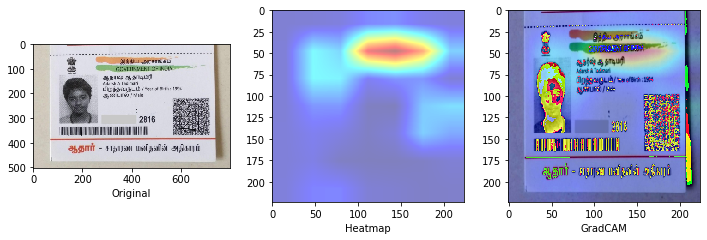

In [28]:
pil_img = Image.open("./adhw.png")
normed_torch_img = test_transform(pil_img).unsqueeze(0).cuda()
resnet = model
resnet.eval()
resnet.cuda()
gradcam = GradCAMpp.from_config(model_type='resnet',
                              arch=resnet, layer_name='layer4')
mask, logit = gradcam(normed_torch_img, class_idx=1)
heatmap, cam_result = visualize_cam(mask, normed_torch_img)
a = transforms.ToPILImage()

heatmap, cam_result = visualize_cam(mask, normed_torch_img)

a = transforms.ToPILImage()

img1 = a(heatmap)
img2 = a(cam_result)
plt.figure(1,figsize=(12,12))
plt.subplot(331)
plt.xlabel('Original')
plt.imshow(pil_img)
plt.subplot(332)
plt.xlabel('Heatmap')
plt.imshow(img1,cmap='jet', alpha = 0.5)
plt.subplot(333)
plt.xlabel('GradCAM')
plt.imshow(img2,cmap='jet')
print(predict(model,'./adhw.png'))

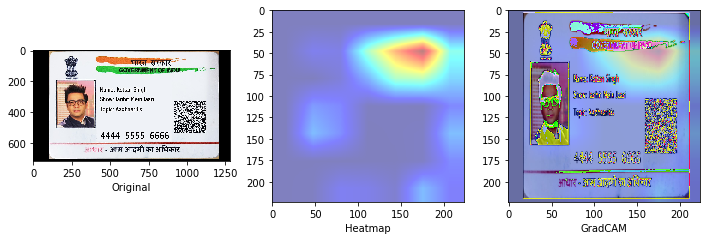

In [74]:
pil_img = Image.open("./00000045.jpg")
normed_torch_img = test_transform(pil_img).unsqueeze(0).cuda()
resnet = model
resnet.eval()
resnet.cuda()
gradcam = GradCAMpp.from_config(model_type='resnet',
                              arch=resnet, layer_name='layer4')
mask, logit = gradcam(normed_torch_img, class_idx=1)
heatmap, cam_result = visualize_cam(mask, normed_torch_img)
a = transforms.ToPILImage()

heatmap, cam_result = visualize_cam(mask, normed_torch_img)

a = transforms.ToPILImage()

img1 = a(heatmap)
img2 = a(cam_result)
plt.figure(1,figsize=(12,12))
plt.subplot(331)
plt.xlabel('Original')
plt.imshow(pil_img)
plt.subplot(332)
plt.xlabel('Heatmap')
plt.imshow(img1,cmap='jet', alpha = 0.5)
plt.subplot(333)
plt.xlabel('GradCAM')
plt.imshow(img2,cmap='jet')



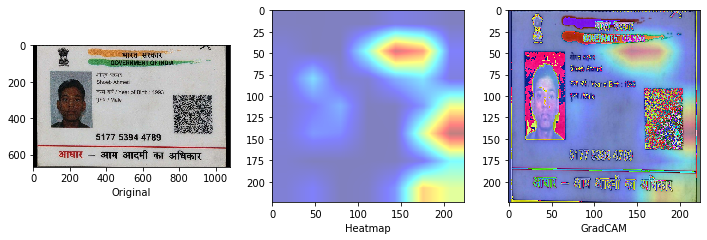

In [75]:
pil_img = Image.open("./adhtest.jpg")
normed_torch_img = test_transform(pil_img).unsqueeze(0).cuda()
resnet = model
resnet.eval()
resnet.cuda()
gradcam = GradCAMpp.from_config(model_type='resnet',
                              arch=resnet, layer_name='layer4')
mask, logit = gradcam(normed_torch_img, class_idx=1)
heatmap, cam_result = visualize_cam(mask, normed_torch_img)
a = transforms.ToPILImage()

heatmap, cam_result = visualize_cam(mask, normed_torch_img)

a = transforms.ToPILImage()

img1 = a(heatmap)
img2 = a(cam_result)
plt.figure(1,figsize=(12,12))
plt.subplot(331)
plt.xlabel('Original')
plt.imshow(pil_img)
plt.subplot(332)
plt.xlabel('Heatmap')
plt.imshow(img1,cmap='jet', alpha = 0.5)
plt.subplot(333)
plt.xlabel('GradCAM')
plt.imshow(img2,cmap='jet')



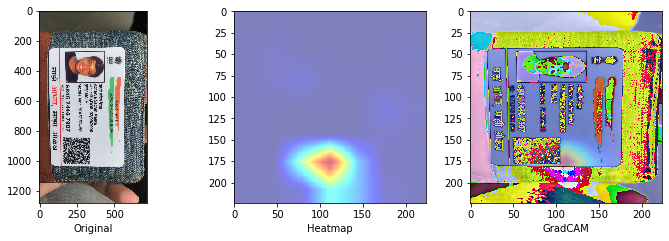

In [76]:
pil_img = Image.open("./Atharva_60.jpeg")
normed_torch_img = test_transform(pil_img).unsqueeze(0).cuda()
resnet = model
resnet.eval()
resnet.cuda()
gradcam = GradCAMpp.from_config(model_type='resnet',
                              arch=resnet, layer_name='layer4')
mask, logit = gradcam(normed_torch_img, class_idx=1)
heatmap, cam_result = visualize_cam(mask, normed_torch_img)
a = transforms.ToPILImage()

heatmap, cam_result = visualize_cam(mask, normed_torch_img)

a = transforms.ToPILImage()

img1 = a(heatmap)
img2 = a(cam_result)
plt.figure(1,figsize=(12,12))
plt.subplot(331)
plt.xlabel('Original')
plt.imshow(pil_img)
plt.subplot(332)
plt.xlabel('Heatmap')
plt.imshow(img1,cmap='jet', alpha = 0.5)
plt.subplot(333)
plt.xlabel('GradCAM')
plt.imshow(img2,cmap='jet')

